In [134]:
import nibabel as nib
import multiprocessing
import os
import numpy as np
import os.path as op
import seaborn as sns
import matplotlib
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.cross_decomposition import PLSRegression
import pickle
from ipyparallel import Client
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
rc = Client()

In [3]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [4]:
exp = 'sim_4mm-betas'
masks = ['entorhinal','peri_sim','para_sim','hipp','yeo17_ifs',
         'lOFC_fill_sim','mOFC_fill_sim','sim_4mm_striatum_mask']
# masks = ['sim_4mm_striatum_limbic_mask','sim_4mm_striatum_frontal_mask']
smooth = 'smoothed'

In [5]:
def get_condition(i):
    if i < 11:
        cond = 'b_plus'
        trial = i
    elif i < 21:
        cond = 'c_plus'
        trial = i - 10
    elif i < 31:
        cond = 'c_minus'
        trial = i - 20
    elif i < 41:
        cond = 'b_minus'
        trial = i - 30
    return cond,trial

In [6]:
overlap_masks = ['peri_sim','para_sim','hipp']


In [7]:
def trim_mask(mask,m):
    exclusions = overlap_masks[:]
    exclusions.remove(m)
    
    for e in exclusions:

        m1 = op.abspath('./data/' + sub + '/masks/' + e +'.nii.gz')
        m1 = nib.load(m1).get_data().astype(bool)

        good = np.invert(m1)
        mask = np.logical_and(mask,good)
    return mask

In [8]:
# #Saves betas to csv so we don't have to constantly rerun this slow code block
# for m in ['VTC_sim']:
#     betas = {'sub':[],'mask':[],'run':[],'condition':[],'trial':[],'value':[],'voxel':[],'row':[]}
#     out_f = op.join(home_dir,'betas', '_'.join([exp,smooth,m]) + '.csv')
    
#     for sub in subs:
#         sub_path = op.join(home_dir,'analysis', exp, sub, 'reg','epi', smooth )

#         mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
#         mask = nib.load(mask).get_data().astype(bool)
#         if m in overlap_masks:
#             mask = trim_mask(mask,m)
            
#         for run in map(str,range(1,4)):
#             run_dir = op.join(sub_path, 'run_'  + run)
            
#             if os.path.exists(run_dir):
                
#                 for i in range(1,41):
#                     f = run_dir + '/cope' + str(i) + '_xfm.nii.gz'
#                     cond, trial = get_condition(i)

#                     #load stat image
#                     stat = nib.load(f).get_data().astype(float)
#                     stat = stat[mask]
                    
#                     for n,val in enumerate(stat):
#                         betas['voxel'].append(n)                        
#                         betas['sub'].append(sub)
#                         betas['value'].append(val)
#                         betas['mask'].append(m)
#                         betas['run'].append(run)
#                         betas['condition'].append(cond)
#                         betas['trial'].append(trial)
#                         betas['row'].append(i)
#             else:
#                 print run_dir

#     betas = pd.DataFrame(betas)
#     betas.to_csv(out_f)
#     del betas

In [9]:
#set ROIs of interest and load from hard disk
def load_betas(rois):
    betas = []
    
    for m in set(rois):
        f = op.join(home_dir,'betas', '_'.join([exp,smooth,m]) + '.csv')
        betas.append(pd.read_csv(f))

    betas = pd.concat(betas)
    betas = betas.set_index(['sub', 'mask','run'])
    
    return betas

In [10]:
def multi_connect(x_roi,y_roi,betas):
    scores_df = {'sub':[],'score_test':[],'score_train':[],'y_roi':[],'x_roi':[]}
    for sub in subs:
        if True:
            scores_train = []
            scores_test = []

            #deal with unequal number of runs across subjects
            runs = list(set(betas.loc[(sub,x_roi)].index))
            if len(runs) == 3:
                train_runs = [['1','2'],['1','3'],['2','3']]
            elif len(runs) == 2:
                train_runs = [['1'],['2']]

            for train_set in train_runs:
                X_train = []
                Y_train = []
                for run in runs:
                    #extract relevant data from betas df
                    X = betas.loc[(sub,x_roi,run)]
                    X = X.pivot(index = 'row',columns='voxel', values='value').values
                    
                    if x_roi == y_roi:
                        Y = np.copy(X)
                    else:    
                        Y = betas.loc[(sub,y_roi,run)]
                        Y = Y.pivot(index = 'row',columns='voxel', values='value').values

                    if str(run) in train_set:
                        X_train.append(np.copy(X))
                        Y_train.append(np.copy(Y))
                    else:
                        X_test = np.copy(X)
                        Y_test = np.copy(Y)

                #format design matrices for input to sklearn
                X_train = np.array(X_train)
                Y_train = np.array(Y_train)        

                X_train = X_train.reshape(-1, X_train.shape[-1])
                Y_train = Y_train.reshape(-1, Y_train.shape[-1])

                #standardize
                X_train = preprocessing.scale(X_train)
                Y_train = preprocessing.scale(Y_train)
                X_test = preprocessing.scale(X_test)
                Y_test = preprocessing.scale(Y_test)

                #compute PLS
                pls = PLSRegression(n_components=2,max_iter = 2000)
                pls.fit(X_train,Y_train)

                score_train = pls.score(X_train,Y_train)
                scores_train.append(score_train)

                score_test = pls.score(X_test,Y_test)
                scores_test.append(score_test)

        #save to DF
        scores_df['sub'].append(sub)
        scores_df['x_roi'].append(x_roi)
        scores_df['y_roi'].append(y_roi)
        scores_df['score_test'].append(np.mean(scores_test))
        scores_df['score_train'].append(np.mean(scores_train))
    
    scores_df = pd.DataFrame(scores_df)
    return scores_df
    

In [11]:
def run_pls(in_tuple):
    x_roi, y_roi = in_tuple
    out_f = op.join(home_dir,'multi_connectivity', x_roi + '_to_' + y_roi + '_sim.pkl')

    if not op.exists(out_f):
        betas = load_betas([x_roi,y_roi])
        scores = multi_connect(x_roi,y_roi,betas)

        # write to a file 
        output = open(out_f, 'wb')
        pickle.dump(scores, output)
        output.close()

In [12]:
rois = ['hipp','peri_sim','entorhinal','para_sim','VTC_sim',
        'mOFC_fill_sim','lOFC_fill_sim','yeo17_ifs',
       'sim_4mm_striatum_limbic_mask','sim_4mm_striatum_frontal_mask']
roi_pairs = []
for i in range(0,len(rois)):
    for j in range(0,len(rois)):
        if i <= j:
            roi_pairs.append((rois[i],rois[j]))


In [37]:
dview = rc[0:8]
dview.block = True

dview.push(dict(home_dir=home_dir,
                exp = exp,
                subs = subs,
                smooth = smooth,
                load_betas = load_betas,
                multi_connect = multi_connect
                ))
dview.execute("import numpy as np")
dview.execute("import os.path as op")
dview.execute("import nibabel as nib")
dview.execute("import pandas as pd")
with dview.sync_imports():
    import os
    import numpy
    import scipy
    import scipy.stats
    import pickle
    import sklearn
    from sklearn import preprocessing
    from sklearn.cross_decomposition import PLSRegression
dview.map_sync(run_pls,roi_pairs)

In [43]:
df = []
for tup in roi_pairs:
    x_roi,y_roi = tup
    out_f = op.join(home_dir,'multi_connectivity', x_roi + '_to_' + y_roi + '_sim.pkl')
    
    if op.exists(out_f):

        pkl_file = open(out_f, 'rb')
        data = pickle.load(pkl_file)

        df.append(data)

        pkl_file.close()
df = pd.concat(df)

In [44]:
means = df.groupby(['x_roi','y_roi']).mean().unstack()['score_test']
df = df.set_index(['x_roi','y_roi'])


In [52]:
sig = {'x_roi':[],'y_roi':[],'sig':[]}
for x in rois:
    for y in rois:
        try:
            vals = df.loc[(x,y),'score_test'].values
        except:
            vals = df.loc[(y,x),'score_test'].values
        is_sig = int(scipy.stats.ttest_1samp(vals,0)[1] > .05)
        
        sig['x_roi'].append(x)
        sig['y_roi'].append(y)
        sig['x_roi'].append(y)
        sig['y_roi'].append(x)
        sig['sig'].append(is_sig)
        sig['sig'].append(is_sig)
sig = pd.DataFrame(sig)
sig = sig.groupby(['x_roi','y_roi']).mean().unstack()['sig']
mask = sig.values
mask[np.triu_indices_from(mask,1)] = True

In [53]:
def make_symmetric(df,rois):
    for n1,x in enumerate(rois):
        for n2,y in enumerate(rois):
            if n1 < n2:
                entry1 = df[x][y]
                entry2 = df[y][x]
                if np.isnan(entry1):
                    df[x][y] = entry2
                if np.isnan(entry2):
                    df[y][x] = entry1
    return df

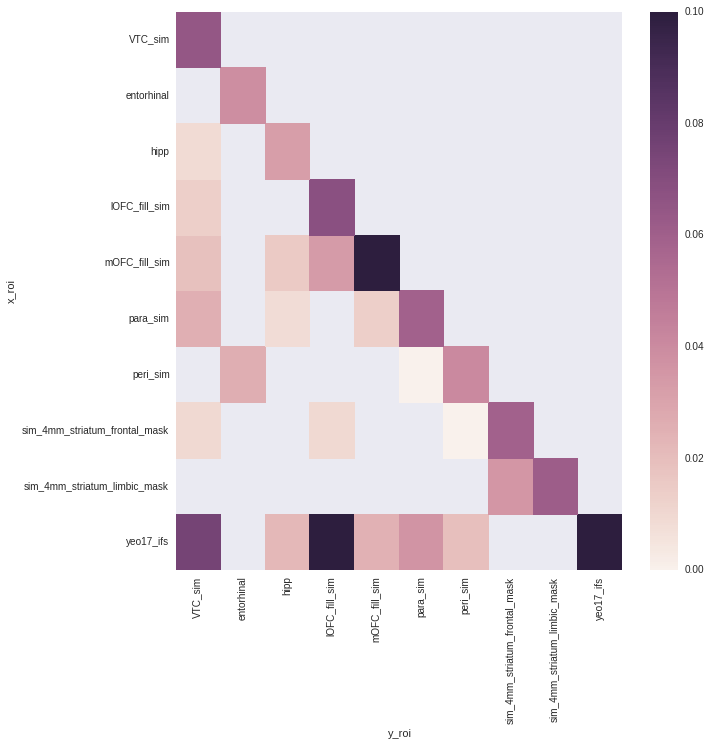

In [54]:

means = make_symmetric(means,rois)
sns.set(rc={"figure.figsize": (10, 10)})
sns.heatmap(means,mask = mask, vmin = 0, vmax = .1)

# examine content of connectivity


In [115]:
x_roi = 'VTC_sim'
y_roi = 'yeo17_ifs'
betas = load_betas([x_roi,y_roi])

In [116]:
sub = 'fd_104'

runs = list(set(betas.loc[(sub,x_roi)].index))

X_train = []
Y_train = []

for run in runs:
    X = betas.loc[(sub,x_roi,run)]
    X = X.pivot(index = 'row',columns='voxel', values='value').values
    X_train.append(np.copy(X))
    
    Y = betas.loc[(sub,y_roi,run)]
    Y = Y.pivot(index = 'row',columns='voxel', values='value').values
    Y_train.append(np.copy(Y))
    

#format design matrices for input to sklearn
X_train = np.array(X_train)
Y_train = np.array(Y_train)        

X_train = X_train.reshape(-1, X_train.shape[-1])
Y_train = Y_train.reshape(-1, Y_train.shape[-1])

#standardize
X_train = preprocessing.scale(X_train)
Y_train = preprocessing.scale(Y_train)

#compute PLS
pls = PLSRegression(n_components=8,max_iter = 2000)
X,Y = pls.fit_transform(X_train,Y_train)



In [133]:

sub_betas = betas.loc[(sub,x_roi)]
runs = sub_betas[sub_betas['voxel'] == 0].index.values
y = sub_betas[sub_betas['voxel'] == 0]['condition'].values

clf = LogisticRegression(C=1)
cv = LeaveOneLabelOut(runs)

res = cross_val_score(clf, Y_train, y, cv=cv, scoring = 'accuracy')

cnf = []
for train_index, test_index in cv:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    cnf.append(cnf_matrix)
cnf = np.array(cnf)
print cnf.mean(0)
print np.mean(res)

[[ 0.33333333  3.          1.33333333  5.33333333]
 [ 0.66666667  2.33333333  1.33333333  5.66666667]
 [ 0.33333333  2.          1.66666667  6.        ]
 [ 1.33333333  2.          0.66666667  6.        ]]
0.375


In [108]:
# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


array([ 0.175,  0.35 ,  0.2  ])

In [103]:
y

array(['b_plus', 'b_plus', 'b_plus', 'b_plus', 'b_plus', 'b_plus',
       'b_plus', 'b_plus', 'b_plus', 'b_plus', 'c_plus', 'c_plus',
       'c_plus', 'c_plus', 'c_plus', 'c_plus', 'c_plus', 'c_plus',
       'c_plus', 'c_plus', 'c_minus', 'c_minus', 'c_minus', 'c_minus',
       'c_minus', 'c_minus', 'c_minus', 'c_minus', 'c_minus', 'c_minus',
       'b_minus', 'b_minus', 'b_minus', 'b_minus', 'b_minus', 'b_minus',
       'b_minus', 'b_minus', 'b_minus', 'b_minus', 'b_plus', 'b_plus',
       'b_plus', 'b_plus', 'b_plus', 'b_plus', 'b_plus', 'b_plus',
       'b_plus', 'b_plus', 'c_plus', 'c_plus', 'c_plus', 'c_plus',
       'c_plus', 'c_plus', 'c_plus', 'c_plus', 'c_plus', 'c_plus',
       'c_minus', 'c_minus', 'c_minus', 'c_minus', 'c_minus', 'c_minus',
       'c_minus', 'c_minus', 'c_minus', 'c_minus', 'b_minus', 'b_minus',
       'b_minus', 'b_minus', 'b_minus', 'b_minus', 'b_minus', 'b_minus',
       'b_minus', 'b_minus', 'b_plus', 'b_plus', 'b_plus', 'b_plus',
       'b_plus', 'b_pl